### Goal

#### Given the ACME customer survey data, our goal is to classify if a customer is happy or not based on the given answers.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from feature_engine.variable_transformers import LogTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
data =  pd.read_csv("D:\Apziva\\ACME-HappinessSurvey2020.csv")

### Exploring the data

In [3]:
data.shape

(126, 7)

In [4]:
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
# The target variable seems to be quite balanced
data["Y"].value_counts()

1    69
0    57
Name: Y, dtype: int64

In [6]:
# Looking for missing values - We don't seem to have any
data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [7]:
# Inspecting the variable values
for var in data.columns:
    print(var, data[var].unique()[0:20])

Y [0 1]
X1 [3 5 4 1]
X2 [3 2 4 5 1]
X3 [3 2 4 5 1]
X4 [4 5 3 2 1]
X5 [2 4 3 5 1]
X6 [4 3 5 2 1]


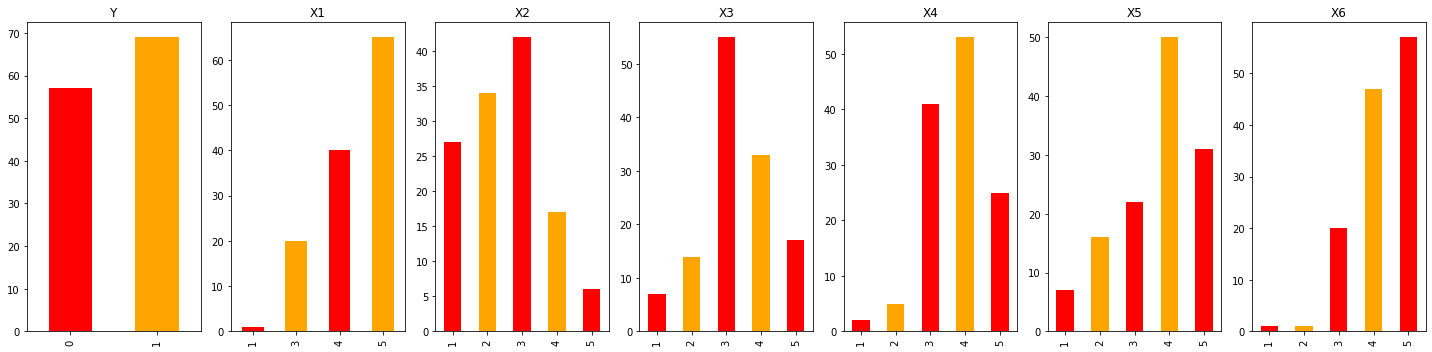

In [8]:
# Exploring the distribution of the data via histograms
fig, axes = plt.subplots(ncols=len(data.columns), figsize=(20,5))
for col, ax in zip(data, axes):
    data[col].value_counts().sort_index().plot.bar(ax=ax, title=col, color=['red', 'orange'])

plt.tight_layout()    
plt.show()

In [9]:
# The distributions is not exactly normal so we would like to achieve a normal distribution

In [10]:
# Splitting the data before training our models
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Y',axis=1), data.Y , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

### Data preprocessing

In [11]:
prep_pipe = Pipeline([
    # Transforming the distribution of the data to look normal
    ('lt', LogTransformer()),
       
    # Scaling the variables although we have 4 variables on the same scale except for one - Scaling via mean normalization
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [12]:
prep_pipe.fit(X_train, y_train)
X_train=prep_pipe.transform(X_train)
X_val=prep_pipe.transform(X_val)
X_test=prep_pipe.transform(X_test)

In [13]:
# creating a scorer for F1 score - The F1 score is a optimal metric choice for this kind of dataset wher
# rather then focusing on just happy or unhappy customers F1 score helps determine the trade off between the two
from sklearn.metrics import fbeta_score, make_scorer
f1score = make_scorer(fbeta_score, beta=1)
f1score

make_scorer(fbeta_score, beta=1)

### Model Training

#### Logistic Regression - with L2 (Ridge) penalty

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

logreg_l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l2'],
                'dual':[True],
                'C':[0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['liblinear'],
                'warm_start':[True,False]}

logreg_l2_grid = GridSearchCV(logreg_l2, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l2_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l2_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l2_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l2_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l2_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.2, 'dual': True, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True} 

Best Mean Cross-validation score: 0.7695571095571095 

Logistic Test Performance:  0.7027027027027027
Logistic Validation Performance:  0.5454545454545454


#### Logistic Regression - with L1 (Lasso) penalty

In [106]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l1'],
                'dual':[False],
                'C':[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1], 
                'fit_intercept':[True,False],
                'solver':['saga'],
#                 'class_weight':[None,'balanced'],
                'warm_start':[True,False]}


logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l1_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l1_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l1_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l1_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l1_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.1, 'dual': False, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.7588578088578088 

Logistic Test Performance:  0.6666666666666666
Logistic Validation Performance:  0.5714285714285715


#### Logistic Regression - Elastic net

In [114]:
logreg_l1l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'class_weight':[None,'balanced'],
                'warm_start':[True,False],
                'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

logreg_l1l2_grid = GridSearchCV(logreg_l1l2, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l1l2_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l1l2_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l1l2_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l1l2_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l1l2_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.7588578088578088 

Logistic Test Performance:  0.6666666666666666
Logistic Validation Performance:  0.5714285714285715


#### Ridge Classifier (L2 Classification)

In [101]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state = 42)

ridge_param = {'alpha':[1,2,5,10,12,15,20,25],
               'fit_intercept':[True,False],
               'normalize':[True,False],
               'copy_X':[True,False],
               'class_weight':[None,'balanced'],
               'solver':['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']
               
}

ridge_grid = GridSearchCV(ridge_clf, ridge_param, cv=10 ,return_train_score=True ,scoring=f1score)
ridge_grid.fit(X_train, y_train)

print('Best Parameters: ', ridge_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(ridge_grid.best_score_), '\n')

print("Test Performance: ", ridge_grid.score(X_test,y_test))
print("Validation Performance: ", ridge_grid.score(X_val,y_val))

Best Parameters:  {'alpha': 5, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'solver': 'auto'} 

Best Mean Cross-validation score: 0.7725407925407927 

Test Performance:  0.6842105263157895
Validation Performance:  0.5294117647058825


#### KNN Classifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

param_knn = {'n_neighbors': range(5,25), 
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'weights':['uniform','distance']}

grid_knn = GridSearchCV(knn, param_knn, cv=10, return_train_score=True, scoring= f1score)
grid_knn.fit(X_train, y_train)

print('Best Parameters: ', grid_knn.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(grid_knn.best_score_), '\n')

print("Test Performance: ", grid_knn.score(X_test,y_test))
print("Validation Performance: ", grid_knn.score(X_val,y_val))

Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'uniform'} 

Best Mean Cross-validation score: 0.7313675213675215 

Test Performance:  0.5185185185185186
Validation Performance:  0.5


#### Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

param_dtree = {"max_depth": [1,2,3,4,5],
           "min_samples_split": [2,3,4],
           "max_leaf_nodes": [2,3,4,5],
           "criterion":['gini'],
           "splitter":['best','random']}

grid_dtree = GridSearchCV(dtree, param_dtree, cv=10, return_train_score = True, scoring= f1score)
grid_dtree.fit(X_train, y_train)

print('Best Parameters: ', grid_dtree.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(grid_dtree.best_score_), '\n')

print("Test Performance: ", grid_dtree.score(X_test,y_test))
print("Validation Performance: ", grid_dtree.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'best'} 

Best Mean Cross-validation score: 0.7894017094017094 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Linear Support Vector Classifier

In [79]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=42)

param = [{'penalty':['l2'],
          'C': [0.001, 0.002, 0.0001, 0.008, 0.01, 0.1], 
          'loss':['hinge','squared_hinge']}]

svc_grid = GridSearchCV(lsvc, param, cv=10 ,return_train_score=True ,scoring=f1score)
svc_grid.fit(X_train, y_train)

print('Best Parameters: ', svc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(svc_grid.best_score_), '\n')

print("Test Performance: ", svc_grid.score(X_test,y_test))
print("Validation Performance: ", svc_grid.score(X_val,y_val))

Best Parameters:  {'C': 0.001, 'loss': 'hinge', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.7588578088578088 

Test Performance:  0.6666666666666666
Validation Performance:  0.5294117647058825


#### Kernel Support Vector Classifier

In [83]:
from sklearn.svm import SVC
svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]},
              {'kernel': ['sigmoid'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]

svm_grid = GridSearchCV(svc, param_grid, cv=10 ,return_train_score=True ,scoring=f1score)
svm_grid.fit(X_train, y_train)

print('Best Parameters: ', svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(svm_grid.best_score_), '\n')

print("Test Performance: ", svm_grid.score(X_test,y_test))
print("Validation Performance: ", svm_grid.score(X_val,y_val))

Best Parameters:  {'degree': 3, 'kernel': 'poly'} 

Best Mean Cross-validation score: 0.7821756021756021 

Test Performance:  0.6470588235294118
Validation Performance:  0.5294117647058825


#### Stochastic Gradient Descent Classifier

In [26]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {'penalty': ['l2', 'l1','elasticnet'],
              'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
                      'alpha': [0.0001, 0.001, 0.01, 0.02, 0.05, 1, 10],
                      'fit_intercept': [True, False],
                      'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                      'eta0': [0.001, 0.01,0.05,0.1,0.2,0.3,0.4,0.5]
                     }    

sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv=10, return_train_score = True, scoring= f1score)
sgdc_grid.fit(X_train, y_train)

print('Best Parameters: ', sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(sgdc_grid.best_score_), '\n')

print("Test Performance: ", sgdc_grid.score(X_test,y_test))
print("Validation Performance: ", sgdc_grid.score(X_val,y_val))

Best Parameters:  {'alpha': 0.05, 'eta0': 0.1, 'fit_intercept': True, 'l1_ratio': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.7652680652680653 

Test Performance:  0.6842105263157895
Validation Performance:  0.5294117647058825


#### QDA

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
param_grid = {
    'reg_param': [0.001,0.01,0.1,0.3,0.5,0.7],
    'priors': [None],
    'reg_param': [0,0.2,0.1],
    'tol': [0.0001, 0.001]
    }    

qda_grid = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, scoring=f1score, cv=10,  n_jobs=-1)

qda_grid.fit(X_train,y_train)

print('Best Parameters: ', qda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(qda_grid.best_score_), '\n')

print("Test Performance: ", qda_grid.score(X_test,y_test))
print("Validation Performance: ", qda_grid.score(X_val,y_val))

Best Parameters:  {'priors': None, 'reg_param': 0.2, 'tol': 0.0001} 

Best Mean Cross-validation score: 0.7422843822843823 

Test Performance:  0.7222222222222222
Validation Performance:  0.5454545454545454


#### LDA

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver' : ['lsqr', 'eigen'],
              'shrinkage': [None, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}    

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring=f1score, cv=10, n_jobs=-1)

lda_grid.fit(X_train,y_train)

print('Best Parameters: ', lda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(lda_grid.best_score_), '\n')

print("Test Performance: ", lda_grid.score(X_test,y_test))
print("Validation Performance: ", lda_grid.score(X_val,y_val))

Best Parameters:  {'shrinkage': 0.3, 'solver': 'lsqr'} 

Best Mean Cross-validation score: 0.7237878787878788 

Test Performance:  0.7096774193548387
Validation Performance:  0.5185185185185185


#### Bootstrap Aggregated Decision Tree

In [122]:
from sklearn.ensemble import BaggingClassifier
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1_param = {
                 'base_estimator__max_depth': [1,2,3],
                 'base_estimator__max_leaf_nodes': [2,3,4,5],
                 'base_estimator__min_samples_split':[2,3,4],
                 'base_estimator__criterion':['gini','entropy'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100,200]}

bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, scoring=f1score)
bag_dtree1_grid.fit(X_train,y_train)

print('Best Parameters: ', bag_dtree1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(bag_dtree1_grid.best_score_), '\n')

print("Test Performance: ", bag_dtree1_grid.score(X_test,y_test))
print("Validation Performance: ", bag_dtree1_grid.score(X_val,y_val))

Best Parameters:  {'base_estimator__max_depth': 1, 'max_samples': 0.8, 'n_estimators': 100} 

Best Mean Cross-validation score: 0.7745153397327311 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Random Forest Classifier

In [121]:
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42, oob_score=False)
rfc_param = { 
    'n_estimators': [20,50,100],
    'max_features': ['auto'],
    'max_depth' : [2,3,4],
    'criterion' :['gini', 'entropy'],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3]
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=10, return_train_score=True, scoring=f1score)
rfc_grid.fit(X_train,y_train)

print('Best Parameters: ', rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(rfc_grid.best_score_), '\n')

print("Test Performance: ", rfc_grid.score(X_test,y_test))
print("Validation Performance: ", rfc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100} 

Best Mean Cross-validation score: 0.7725252525252525 

Test Performance:  0.6470588235294118
Validation Performance:  0.6451612903225806


In [126]:
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42, oob_score=False)
rfc_param = { 
    'n_estimators': [100,200,250,300,350,500],
    'max_features': ['auto'],
    'max_depth' : [2,3,4],
    'criterion' :['gini'],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=10, return_train_score=True, scoring=f1score)
rfc_grid.fit(X_train,y_train)

print('Best Parameters: ', rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(rfc_grid.best_score_), '\n')

print("Test Performance: ", rfc_grid.score(X_test,y_test))
print("Validation Performance: ", rfc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200} 

Best Mean Cross-validation score: 0.7821756021756021 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Extra Trees Classfier

In [127]:
from  sklearn.ensemble import ExtraTreesClassifier
etc= ExtraTreesClassifier(random_state=42)
etc_param = { 
    'n_estimators': [20, 50, 150, 500],
    'max_features': ['auto'],
    'max_depth' : [2,3,4,10,12],
    'criterion' :['gini','entropy'],
    'min_samples_split':[2,3,5,7,9],
    'min_samples_leaf':[1,2,3]
}
etc_grid = GridSearchCV(etc, etc_param, cv=10, return_train_score=True, scoring=f1score)
etc_grid.fit(X_train,y_train)

print('Best Parameters: ', etc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(etc_grid.best_score_), '\n')

print("Test Performance: ", etc_grid.score(X_test,y_test))
print("Validation Performance: ", etc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50} 

Best Mean Cross-validation score: 0.7915695415695416 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### AdaBoost Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
adc_dtree =AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
adc_dtree_param = {
              'base_estimator__splitter' :   ['best','random'],
              'base_estimator__max_depth' : [1,2,3],
              'base_estimator__min_samples_split':[2,3,4],
              'base_estimator__min_samples_leaf':[1,2,3],
              'algorithm' : ['SAMME', 'SAMME.R'],
              'n_estimators' : [20,50,100,150,300],
              'learning_rate' : [0.6, 0.7, 0.8,1],
             }

adc_dtree_grid = RandomizedSearchCV(adc_dtree, adc_dtree_param, cv=10, return_train_score=True, scoring=f1score)
adc_dtree_grid.fit(X_train,y_train)

print('Best Parameters: ', adc_dtree_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(adc_dtree_grid.best_score_), '\n')

print("Test Performance: ", adc_dtree_grid.score(X_test,y_test))
print("Validation Performance: ", adc_dtree_grid.score(X_val,y_val))

Best Parameters:  {'n_estimators': 20, 'learning_rate': 1, 'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__max_depth': 1, 'algorithm': 'SAMME'} 

Best Mean Cross-validation score: 0.6787878787878787 

Test Performance:  0.6857142857142856
Validation Performance:  0.625


#### Gradient Boosting Classifier

In [32]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)
gbc_param = {
              'min_samples_split':[2,3,4,5,6],
              'subsample':[0.8,1],
              'min_samples_leaf':[1,2,3],
              'max_depth' : [1,2,3,4],
#               'max_features':['auto'],
              'n_estimators' : [20,50,100,150],
              'learning_rate' : [0.2,0.3,0.7,0.5,0.9],
              'warm_start' : [True, False]
             }

gbc_grid = GridSearchCV(gbc, gbc_param,cv=10, return_train_score=True, scoring=f1score)
gbc_grid.fit(X_train,y_train)

print('Best Parameters: ', gbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(gbc_grid.best_score_), '\n')

print("Test Performance: ", gbc_grid.score(X_test,y_test))
print("Validation Performance: ", gbc_grid.score(X_val,y_val))

Best Parameters:  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20, 'subsample': 1, 'warm_start': True} 

Best Mean Cross-validation score: 0.7731351981351979 

Test Performance:  0.6666666666666667
Validation Performance:  0.6206896551724138


#### XGBoost Classifier

In [18]:
from xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42, n_jobs=-1, objective = 'binary:logistic')
xgbc_param = {
              'max_depth' : [2,3,4],
              'learning_rate':[0.001, 0.01, 0.1],
              'early_stopping_rounds':[10,15],
              'n_estimators' : [20,50,100,500],
              'eta':[0.01,0.025,0.05,0.1],
              'gamma' : [0.6,0.8,1],
              'min_child_weight' : [1,2,3],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.7, 0.9, 1]
             }


xgbc_grid = GridSearchCV(xgbc, xgbc_param, cv=10, return_train_score=True, scoring = f1score)
xgbc_grid.fit(X_train,y_train)

print('Best Parameters: ', xgbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(xgbc_grid.best_score_), '\n')

print("Test Performance: ", xgbc_grid.score(X_test,y_test))
print("Validation Performance: ", xgbc_grid.score(X_val,y_val))

Best Parameters:  {'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eta': 0.01, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1} 

Best Mean Cross-validation score: 0.7957109557109556 

Test Performance:  0.6470588235294118
Validation Performance:  0.6451612903225806


#### CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
cat = CatBoostClassifier()

param_grid = {
            'depth':[1,2,3,4,7],
            'iterations':[250,100,500,1000], 
            'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
            'l2_leaf_reg':[3,1,5,10,100], 
            'border_count':[32,5,10,20,50,100,200]
                      }

cat_grid = RandomizedSearchCV(cat, param_grid, cv=10, return_train_score=True, scoring = f1score)
cat_grid.fit(X_train,y_train)

print('Best Parameters: ', cat_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(cat_grid.best_score_), '\n')

print("Test Performance: ", cat_grid.score(X_test,y_test))
print("Validation Performance: ", cat_grid.score(X_val,y_val)) 

Best Parameters:  {'learning_rate': 0.001, 'l2_leaf_reg': 10, 'iterations': 500, 'depth': 1, 'border_count': 100} 

Best Mean Cross-validation score: 0.778951048951049 

Test Performance:  0.6666666666666667
Validation Performance:  0.6060606060606061

#### LightGBM

In [30]:
import lightgbm as lgb
param_grid = {'num_leaves': [10,20,30,40,50,60,70,80,90,100,150,200],
              'max_depth': [1,2,3,4],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'n_estimators': [10, 30, 50, 70, 90, 100, 120, 150, 170, 200], 
              'min_split_gain' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

mdl = lgb.LGBMClassifier(random_state=42,
                         objective = 'binary')

lgbm_grid = RandomizedSearchCV(mdl, param_grid, cv=10, return_train_score=True, scoring = f1score)
lgbm_grid.fit(X_train,y_train)

print('Best Parameters: ', lgbm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(lgbm_grid.best_score_), '\n')

print("Test Performance: ", lgbm_grid.score(X_test,y_test))
print("Validation Performance: ", lgbm_grid.score(X_val,y_val)) 

Best Parameters:  {'reg_lambda': 0.4, 'reg_alpha': 0.7, 'num_leaves': 200, 'n_estimators': 30, 'min_split_gain': 0.9, 'max_depth': 3, 'learning_rate': 0.1} 

Best Mean Cross-validation score: 0.7361305361305363 

Test Performance:  0.6666666666666666
Validation Performance:  0.5714285714285715


#### MLP Classifier

In [25]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter = 500, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv=10, return_train_score=True, scoring = f1score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {}".format(mlp_clf.best_score_), '\n')

print("Test Performance: ", mlp_clf.score(X_test,y_test))
print("Validation Performance: ", mlp_clf.score(X_val,y_val)) 

Best Mean Cross-validation score: 0.7783372183372184 

Test Performance:  0.6857142857142856
Validation Performance:  0.5161290322580645


In [24]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(6,3), max_iter = 10000, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv=10, return_train_score=True, scoring = f1score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {}".format(mlp_clf.best_score_), '\n')

print("Test Performance: ", mlp_clf.score(X_test,y_test))
print("Validation Performance: ", mlp_clf.score(X_val,y_val)) 

Best Mean Cross-validation score: 0.6977855477855477 

Test Performance:  0.7647058823529412
Validation Performance:  0.5517241379310345


### Results

Understanding what data the results are validated on:

The Mean Cross Validation Score tells us how well a model has performed with the traning data cross validated with 10 folds - Our training data consists of 77/127 observations.

Testing and Validation Set have 25/127 observations.

#### Best Model Performance

- Based on a model that would perform better on newer data the best model in my opnon would be the XGBoost Classifier




- Best Parameters for the XGB Classifier:  {'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eta': 0.01, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1} 


- Best Mean Cross-validation score: 0.7957109557109556 

- Test Performance:  0.6470588235294118
- Validation Performance:  0.6451612903225806

- Many other models such as the MLP Classifier, QDA, Ridge Classifier, Logistic Regression, AdaBoost gave us really good results on just these particular test and validation sets but may not generalise well on future data

- Having access to more data would severely improve performance of many models and be in a position to make better predictions

#### Importance of Survey Questions

- Ridge or L2 regularised model is often considered to be a good feature selector especially in high dimensional datasets (in contrary to our case) due to its ability to penalise attributes that may not be of much value to the model's prediction.

- The ridge classifier has performed moderately well as comapred to most other models and observing it's coefficient values will give us a good idea of what features are relevant.

In [21]:
# Using Logistic regression with l2 - ridge penalty
logreg_l2 = LogisticRegression(C = 0.1, dual = True, fit_intercept = True, penalty = 'l2', solver = 'liblinear', 
                               max_iter=10000, random_state=42)
logreg_l2.fit(X_train,y_train)

# Identifying which columns have been given preference while making the predictions by checking coefficient values
print('Coefficient of each feature:', logreg_l2.coef_)

# As we can see from the coefficient values below the order of preference given to the variables in the prediction are:
# X6 > X3 > X5 > X1 > X4 > X2

Coefficient of each feature: [[0.10325073 0.01079386 0.15283796 0.01372126 0.14921793 0.22424348]]


In [29]:
ridge_clf = RidgeClassifier(alpha = 5, copy_X = True, fit_intercept = True, solver = 'auto', 
                               normalize = True, class_weight = None, random_state=42)
ridge_clf.fit(X_train,y_train)

# Identifying which columns have been given preference while making the predictions by checking coefficient values
print('Coefficient of each feature:', ridge_clf.coef_)

# As we can see from the coefficient values below the order of preference given to the variables in the prediction are:
# X1 > X3 > X5 > X6 > X4 > X2

Coefficient of each feature: [[0.20329293 0.0018647  0.1484375  0.01666328 0.10015983 0.0848951 ]]


- Based on the coefficient values of the above models it is evident that X2 (contents of my order was as I expected) and X4 (I paid a good price for my order) are both questions that added little to no value in predicting if a customer was happy and are potentially a good choice for questions that could be removed in following surveys. 